<a href="https://colab.research.google.com/github/thomasamged/dogs_cats_voices/blob/main/dog_cat_voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mmoreaux_audio_cats_and_dogs_path = kagglehub.dataset_download('mmoreaux/audio-cats-and-dogs')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import librosa
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Flatten,Conv1D,MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report,auc
from sklearn.metrics._plot.roc_curve import roc_curve

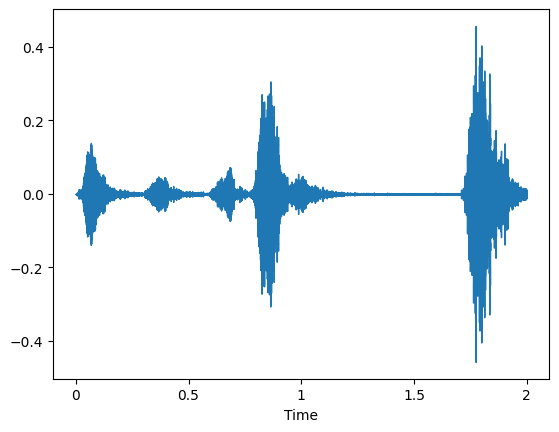

In [ ]:
sound,sr=librosa.load("/kaggle/input/audio-cats-and-dogs/cats_dogs/train/dog/dog_barking_0.wav",duration=duration)
librosa.display.waveshow(sound,sr=sr)
ipd.Audio("/kaggle/input/audio-cats-and-dogs/cats_dogs/train/dog/dog_barking_0.wav")


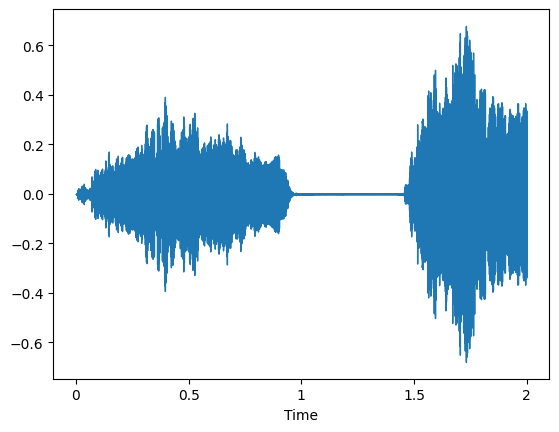

In [ ]:
sound,sr=librosa.load("/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_10.wav",duration=duration)
librosa.display.waveshow(sound,sr=sr)
ipd.Audio("/kaggle/input/audio-cats-and-dogs/cats_dogs/train/cat/cat_10.wav",)


In [ ]:
train_path="/kaggle/input/audio-cats-and-dogs/cats_dogs/train"
label=[]
feature=[]
sr=22050
duration=2
track=sr*duration
for i in os.listdir(train_path):
    for file in os.listdir(os.path.join(train_path,i)):
        if file.endswith(".wav"):
            path=os.path.join(train_path,i,file)
            sound,sr=librosa.load(path,duration=duration,sr=sr)
            if len(sound)<track:
               sound=np.pad(sound,(0, track - len(sound)),"constant")
            feature.append(sound)
            label.append(0 if i=="cat" else 1)


In [ ]:
X=np.array(feature)
y=np.array(label)

In [ ]:
ros=RandomOverSampler()
X_re,y_re=ros.fit_resample(X,y)
np.bincount(y_re)

array([125, 125])

In [ ]:
X_re = X_re.reshape(-1, track, 1)

In [ ]:
X_re.shape

(250, 44100, 1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_re, y_re, test_size=0.2, random_state=42)

In [ ]:
model=Sequential([
    Conv1D(32,4,activation="relu",input_shape=(track, 1)),
    MaxPooling1D(2),
    Conv1D(64,4,activation="relu"),
    MaxPooling1D(2),
    Conv1D(128,4,activation="relu"),
    MaxPooling1D(2),
    Flatten(),
    Dense(64,activation="relu"),
    Dense(1,"sigmoid")
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_44 (Conv1D)              │ (None, 44095, 32)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 22047, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 22042, 64)      │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 11021, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 11016, 128)     │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 5508, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 705024)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │    45,121,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,183,521 (172.36 MB)

 Trainable params: 45,183,521 (172.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train,y_train,epochs=50,validation_data=(X_val, y_val),batch_size=32,callbacks=early_stopping)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.5503 - loss: 1.3569 - val_accuracy: 0.6200 - val_loss: 0.6712
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.7867 - loss: 0.5912 - val_accuracy: 0.8000 - val_loss: 0.5276
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.8751 - loss: 0.4458 - val_accuracy: 0.8000 - val_loss: 0.4486
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.8811 - loss: 0.3077 - val_accuracy: 0.8400 - val_loss: 0.3670
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.9221 - loss: 0.2052 - val_accuracy: 0.8600 - val_loss: 0.3092
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.9666 - loss: 0.1176 - val_accuracy: 0.8400 - val_loss: 0.4102
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.9918 - loss: 0.0636 - val_accuracy: 0.9200 - val_loss: 0.1908
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9944 - loss: 0.0259 - val_accuracy: 0.9400 - val_loss:

In [ ]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9154 - loss: 0.2091


[0.18755871057510376, 0.9200000166893005]

In [ ]:
test_path="/kaggle/input/audio-cats-and-dogs/cats_dogs/test"
label1=[]
feature1=[]
for i in os.listdir(test_path):
    for file in os.listdir(os.path.join(test_path,i)):
        if file.endswith(".wav") or file.endswith(".wav") :
            path=os.path.join(test_path,i,file)
            sound,sr=librosa.load(path,duration=duration,sr=sr)
            if len(sound)<track:
               sound=np.pad(sound,(0, track - len(sound)),"constant")
            feature1.append(sound)
            label1.append(0 if i=="cats" else 1)


In [ ]:
X_test=np.array(feature1)
y_test=np.array(label1)

In [ ]:
y_test.shape

(67,)

In [ ]:
np.bincount(y_test)

array([39, 28])

In [ ]:
X_test=X_test.reshape(-1,track,1)

In [ ]:
X_test.shape

(67, 44100, 1)

In [ ]:
model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9044 - loss: 0.4325


[0.37889549136161804, 0.9104477763175964]

In [ ]:
pre=model.predict(X_test)
predict=[]
for i in pre:
    if i<.5:
        predict.append(0)
    else:
        predict.append(1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
print(classification_report(predict,y_test))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        41
           1       0.86      0.92      0.89        26

    accuracy                           0.91        67
   macro avg       0.90      0.91      0.91        67
weighted avg       0.91      0.91      0.91        67



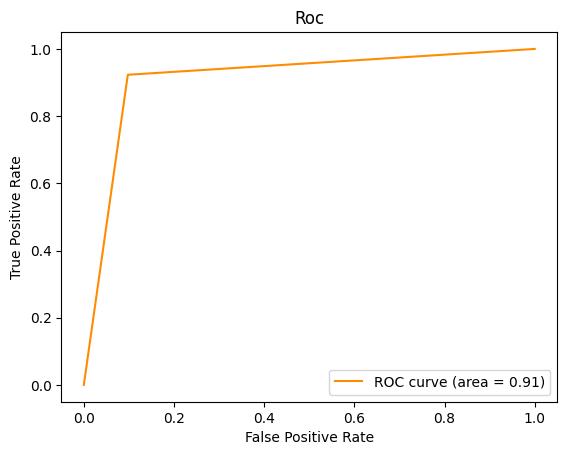

In [ ]:
fpr,tpr,thres=roc_curve(predict,y_test)
roc_auc=auc(fpr,tpr)
plt.plot(fpr,tpr, color="darkorange",label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Roc")
plt.legend(loc="lower right")
plt.show()